# Detección de Fraude - Análisis de Clientes con Mayor Probabilidad de Fraude No Detectado

Este notebook analiza las cuatro tablas disponibles para identificar los 20 clientes con mayor probabilidad de estar cometiendo fraude sin haber sido detectados.

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configurar visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Carga y Exploración de Datos

In [2]:
# Cargar las cuatro tablas
contadores = pd.read_csv('../data/inputs/datos_contador.csv')
expedientes = pd.read_csv('../data/inputs/expedientes.csv')
metricas = pd.read_csv('../data/inputs/metricas.csv')
eventos = pd.read_csv('../data/inputs/datos_eventos_enero_a_julio_2025.csv')

print("Dimensiones de las tablas:")
print(f"Contadores: {contadores.shape}")
print(f"Expedientes: {expedientes.shape}")
print(f"Métricas: {metricas.shape}")
print(f"Eventos: {eventos.shape}")

Dimensiones de las tablas:
Contadores: (615440, 21)
Expedientes: (21760, 36)
Métricas: (521990, 335)
Eventos: (89526487, 4)


In [3]:
# Explorar la estructura de cada tabla
print("=== CONTADORES ===")
print(contadores.head())
print(f"\nColumnas: {list(contadores.columns)}")

print("\n=== EXPEDIENTES ===")
print(expedientes.head())
print(f"\nColumnas: {list(expedientes.columns)}")

print("\n=== MÉTRICAS ===")
print(metricas.head())
print(f"\nColumnas: {list(metricas.columns)}")

print("\n=== EVENTOS ===")
print(eventos.head())
print(f"\nColumnas: {list(eventos.columns)}")

=== CONTADORES ===
                 cups_sgc  tipo_punto_suministro  \
0  ES0022000007921748YY1P                    NaN   
1  ES0022000005534933FQ1P                    5.0   
2  ES0022000009030743SX1P                    5.0   
3  ES0022000001315001AD1P                    NaN   
4  ES0022000007687772ED1P                    5.0   

                                     tipo_suministro       fases tarifa  \
0                                             NORMAL         NaN    NaN   
1                                             NORMAL  MONOFÁSICO  2.0TD   
2                                             NORMAL  MONOFÁSICO  2.0TD   
3  33-AUTOCONSUMO PRODUCTOR CON EXCEDENTES CON CO...         NaN    NaN   
4                                             NORMAL  MONOFÁSICO  2.0TD   

  fecha_instalacion_aparato fecha_alta_contrato fecha_baja_contrato  \
0                       NaN                 NaN                 NaN   
1                2015-11-03          2009-06-30                 NaN   
2   

In [4]:
# Función para detectar patrones de eventos críticos en ventana temporal de ±1 hora
def detectar_eventos_criticos_ventana_temporal(df_eventos):
    """
    Detecta si para cada evento, en una ventana de ±1 hora existe al menos un evento
    de cada uno de los grupos 1, 2 y 4 para el mismo cups_sgc.
    """
    # Asegurar que fecha_hora_evento es datetime
    df = df_eventos.copy()
    df['fecha_hora_evento'] = pd.to_datetime(df['fecha_hora_evento'])
    
    # Ordenar por cups_sgc y fecha_hora_evento para optimizar búsquedas
    df = df.sort_values(['cups_sgc', 'fecha_hora_evento']).reset_index(drop=True)
    
    # Inicializar la nueva columna
    df['eventos_4_1_2_una_hora'] = False
    
    # Grupos que deben estar presentes (todos obligatorios)
    grupos_requeridos = {1, 2, 4}
    
    print("Procesando eventos para detectar patrones críticos...")
    print(f"Total de eventos a procesar: {len(df)}")
    
    # Procesar cada evento
    for idx, evento_actual in df.iterrows():
        if idx % 1000 == 0:  # Mostrar progreso cada 1000 eventos
            print(f"Procesado: {idx}/{len(df)} eventos ({idx/len(df)*100:.1f}%)")
        
        cups_actual = evento_actual['cups_sgc']
        fecha_actual = evento_actual['fecha_hora_evento']
        
        # Definir ventana temporal de ±1 hora
        ventana_inicio = fecha_actual - pd.Timedelta(hours=1)
        ventana_fin = fecha_actual + pd.Timedelta(hours=1)
        
        # Filtrar eventos del mismo cliente en la ventana temporal
        eventos_ventana = df[
            (df['cups_sgc'] == cups_actual) &
            (df['fecha_hora_evento'] >= ventana_inicio) &
            (df['fecha_hora_evento'] <= ventana_fin)
        ]
        
        # Obtener grupos únicos en la ventana
        grupos_en_ventana = set(eventos_ventana['grupo_evento'].unique())
        
        # Verificar si todos los grupos requeridos están presentes
        tiene_todos_grupos = grupos_requeridos.issubset(grupos_en_ventana)
        
        df.at[idx, 'eventos_4_1_2_una_hora'] = tiene_todos_grupos
    
    print("Procesamiento completado!")
    return df

In [ ]:
eventos = detectar_eventos_criticos_ventana_temporal(eventos)

Procesando eventos para detectar patrones críticos...
Total de eventos a procesar: 89526487
Procesado: 0/89526487 eventos (0.0%)


In [4]:
# Identificar la columna de ID de cliente en cada tabla
print("Identificando columnas de ID de cliente:")
for nombre, tabla in [('contadores', contadores), ('expedientes', expedientes), 
                      ('metricas', metricas), ('eventos', eventos)]:
    cols_cups = [col for col in tabla.columns if 'cups' in col.lower()]
    print(f"{nombre}: {cols_cups}")

Identificando columnas de ID de cliente:
contadores: ['cups_sgc']
expedientes: ['cups_sgc']
metricas: ['cups_sgc']
eventos: ['cups_sgc']


## 2. Análisis de Fraudes Conocidos

In [5]:
# Analizar los fraudes conocidos (grupo_evento = 4)
fraudes_conocidos = eventos[eventos['grupo_evento'] == 4]
print(f"Número de eventos de fraude detectados: {len(fraudes_conocidos)}")
print(f"Número de clientes únicos con fraude detectado: {fraudes_conocidos['cups_sgc'].nunique()}")

# Ver distribución de grupo_evento
print("\nDistribución de grupo_evento:")
print(eventos['grupo_evento'].value_counts().sort_index())

Número de eventos de fraude detectados: 2148777
Número de clientes únicos con fraude detectado: 107313

Distribución de grupo_evento:
grupo_evento
1     1925318
2      400678
3     8672530
4     2148777
5      631846
6    75727220
7       20118
Name: count, dtype: int64
grupo_evento
1     1925318
2      400678
3     8672530
4     2148777
5      631846
6    75727220
7       20118
Name: count, dtype: int64


## 3. Unión de Tablas y Preparación de Datos

In [6]:
# Obtener lista de clientes con fraude conocido
clientes_fraude_conocido = set(fraudes_conocidos['cups_sgc'].unique())
print(f"Clientes con fraude conocido: {len(clientes_fraude_conocido)}")

# Estandarizar nombres de columnas de ID
def estandarizar_cups(df, col_name):
    df_copy = df.copy()
    if col_name in df_copy.columns:
        df_copy.rename(columns={col_name: 'cups'}, inplace=True)
    return df_copy

# Estandarizar todas las tablas
contadores_std = estandarizar_cups(contadores, 'cups_sgc')
expedientes_std = estandarizar_cups(expedientes, 'cups_sgc') 
metricas_std = estandarizar_cups(metricas, 'cups_sgc')
eventos_std = estandarizar_cups(eventos, 'cups_sgc')

# CORREGIR: Crear agregaciones por cliente desde la tabla de eventos usando las columnas correctas
eventos_agg = eventos_std.groupby('cups').agg({
    'grupo_evento': ['count', 'nunique', lambda x: (x == 4).sum()],
    'evento': ['nunique', 'count'],  # Usar 'evento' que sí existe
    'fecha_hora_evento': ['min', 'max', 'count']  # Usar 'fecha_hora_evento' que sí existe
}).round(3)

# Aplanar nombres de columnas
eventos_agg.columns = ['_'.join(col).strip() for col in eventos_agg.columns]
eventos_agg = eventos_agg.reset_index()

# Renombrar columnas más claramente
eventos_agg.rename(columns={
    'grupo_evento_count': 'total_eventos',
    'grupo_evento_nunique': 'tipos_grupo_evento', 
    'grupo_evento_<lambda_0>': 'eventos_fraude',
    'evento_nunique': 'tipos_evento_unicos',      # Corregido
    'evento_count': 'total_tipo_eventos',         # Corregido
    'fecha_hora_evento_min': 'primer_evento',     # Corregido
    'fecha_hora_evento_max': 'ultimo_evento',     # Corregido
    'fecha_hora_evento_count': 'total_fechas_evento'  # Corregido
}, inplace=True)

print("Agregaciones de eventos por cliente:")
print(eventos_agg.head())

Clientes con fraude conocido: 107313
Agregaciones de eventos por cliente:
                     cups  total_eventos  tipos_grupo_evento  eventos_fraude  \
0  ES0022000001000029QE1P            168                   3               7   
1  ES0022000001000030VT1P            130                   1               0   
2  ES0022000001000031VR1P            125                   2               0   
3  ES0022000001000032VW1P            197                   4              22   
4  ES0022000001000033VA1P            220                   1               0   

   tipos_evento_unicos  total_tipo_eventos            primer_evento  \
0                    4                 168  2025-07-06 20:00:00.000   
1                    2                 130  2025-07-01 00:00:00.000   
2                    3                 125  2025-07-01 01:00:00.000   
3                    8                 197  2025-07-01 00:00:00.000   
4                    2                 220  2025-07-01 02:00:00.000   

             ultim

In [7]:
# Unir todas las tablas
# Comenzar con contadores como base
datos_unidos = contadores_std.copy()

# Unir expedientes
if not expedientes_std.empty:
    datos_unidos = datos_unidos.merge(expedientes_std, on='cups', how='left', suffixes=('', '_exp'))

# Unir métricas
if not metricas_std.empty:
    datos_unidos = datos_unidos.merge(metricas_std, on='cups', how='left', suffixes=('', '_met'))

# Unir eventos agregados
datos_unidos = datos_unidos.merge(eventos_agg, on='cups', how='left', suffixes=('', '_evt'))

print(f"Datos unidos: {datos_unidos.shape}")
print(f"Columnas finales: {len(datos_unidos.columns)}")

Datos unidos: (619972, 398)
Columnas finales: 398


In [8]:
# Marcar clientes con fraude conocido
datos_unidos['fraude_conocido'] = datos_unidos['cups'].isin(clientes_fraude_conocido)
datos_unidos['eventos_fraude'] = datos_unidos['eventos_fraude'].fillna(0)

print(f"Clientes con fraude conocido en datos unidos: {datos_unidos['fraude_conocido'].sum()}")
print(f"Clientes sin fraude conocido: {(~datos_unidos['fraude_conocido']).sum()}")

# Ver algunas estadísticas básicas
print("\nEstadísticas de eventos de fraude:")
print(datos_unidos['eventos_fraude'].describe())

Clientes con fraude conocido en datos unidos: 108804
Clientes sin fraude conocido: 511168

Estadísticas de eventos de fraude:
count    619972.000000
mean          3.511254
std           9.716476
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         262.000000
Name: eventos_fraude, dtype: float64


## 4. Ingeniería de Características

In [9]:
# Seleccionar características numéricas para el análisis
caracteristicas_numericas = datos_unidos.select_dtypes(include=[np.number]).columns.tolist()

# Remover columnas que no son útiles para predicción
excluir = ['fraude_conocido', 'eventos_fraude']
caracteristicas_numericas = [col for col in caracteristicas_numericas if col not in excluir]

print(f"Características numéricas disponibles: {len(caracteristicas_numericas)}")
print("Primeras 20 características:")
print(caracteristicas_numericas[:20])

# Verificar valores faltantes
datos_modelo = datos_unidos[caracteristicas_numericas + ['fraude_conocido', 'eventos_fraude', 'cups']].copy()
print(f"\nValores faltantes por columna:")
valores_faltantes = datos_modelo.isnull().sum()
print(valores_faltantes[valores_faltantes > 0])

Características numéricas disponibles: 357
Primeras 20 características:
['tipo_punto_suministro', 'coordenada_x', 'coordenada_y', 'codigo_postal', 'identificador_actividad_economica', 'potencia_contrato', 'potencia_maxima_contrato', 'tension_suministro', 'dg', 'nis', 'energia_facturada', 'valoracion_total', 'num_ooss', 'dias_liquidables', 'pct_liquidable', 'energia_liquidable', 'codigo_comercializadora', 'data_date', 'consumo_suma_semana_actual', 'consumo_media_semana_actual']

Valores faltantes por columna:
tipo_punto_suministro                 59267
coordenada_x                           1068
coordenada_y                           1068
identificador_actividad_economica     29291
potencia_contrato                     87434
                                      ...  
total_eventos                        155571
tipos_grupo_evento                   155571
tipos_evento_unicos                  155571
total_tipo_eventos                   155571
total_fechas_evento                  155571
Le

In [10]:
# Imputar valores faltantes y crear características adicionales
from sklearn.impute import SimpleImputer

# Verificar y limpiar datos antes de la imputación
print("Verificando datos numéricos...")
print(f"Forma de datos_numericos: {datos_modelo[caracteristicas_numericas].shape}")

# Crear una copia y limpiar valores problemáticos
datos_numericos = datos_modelo[caracteristicas_numericas].copy()

# Reemplazar valores infinitos y extremadamente grandes
print("Limpiando valores infinitos y extremos...")
datos_numericos = datos_numericos.replace([np.inf, -np.inf], np.nan)

# Verificar valores extremadamente grandes (mayores que el límite de float64)
mask_large = np.abs(datos_numericos) > 1e100
if mask_large.any().any():
    print(f"Se encontraron {mask_large.sum().sum()} valores extremadamente grandes")
    datos_numericos = datos_numericos.where(~mask_large, np.nan)

# Eliminar columnas que tienen solo valores NaN después de la limpieza
print("Eliminando columnas que son completamente NaN después de la limpieza...")
columnas_validas = datos_numericos.columns[~datos_numericos.isnull().all()].tolist()
datos_numericos_limpios = datos_numericos[columnas_validas]

print(f"Columnas eliminadas: {len(caracteristicas_numericas) - len(columnas_validas)}")
print(f"Forma después de limpieza: {datos_numericos_limpios.shape}")

# Mostrar estadísticas después de la limpieza
print("Estadísticas después de limpieza:")
print(f"Valores NaN por columna:")
nan_counts = datos_numericos_limpios.isnull().sum()
print(nan_counts[nan_counts > 0])

# Imputar valores faltantes con la mediana
imputer = SimpleImputer(strategy='median')
datos_numericos_imputados = pd.DataFrame(
    imputer.fit_transform(datos_numericos_limpios),
    columns=columnas_validas,
    index=datos_numericos_limpios.index
)

# Verificar si tenemos columnas de eventos en datos_modelo para agregar características derivadas
print("Columnas disponibles relacionadas con eventos:")
eventos_cols = [col for col in datos_modelo.columns if 'evento' in col.lower() or 'total' in col.lower()]
print(eventos_cols)

# Agregar características derivadas si hay suficientes datos de eventos
if 'total_eventos' in datos_modelo.columns:
    # Agregar total_eventos como característica
    datos_numericos_imputados['total_eventos'] = datos_modelo['total_eventos'].fillna(0)
    
    if 'eventos_fraude' in datos_modelo.columns:
        # Crear ratio evitando división por cero
        total_eventos_safe = datos_modelo['total_eventos'].fillna(0) + 1
        datos_numericos_imputados['ratio_fraude_eventos'] = (
            datos_modelo['eventos_fraude'].fillna(0) / total_eventos_safe
        )
    
    datos_numericos_imputados['actividad_eventos'] = datos_modelo['total_eventos'].fillna(0)
    print("Características de eventos agregadas exitosamente")
else:
    print("No se encontró la columna 'total_eventos'. Continuando sin características derivadas de eventos.")

# Crear dataset final para modelado
X = datos_numericos_imputados
y = datos_modelo['fraude_conocido']
clientes_ids = datos_modelo['cups']

print(f"Dataset para modelado: {X.shape}")
print(f"Distribución de clases: {y.value_counts()}")

Verificando datos numéricos...
Forma de datos_numericos: (619972, 357)
Limpiando valores infinitos y extremos...
Eliminando columnas que son completamente NaN después de la limpieza...
Columnas eliminadas: 10
Forma después de limpieza: (619972, 347)
Estadísticas después de limpieza:
Valores NaN por columna:
tipo_punto_suministro                 59267
coordenada_x                           1068
coordenada_y                           1068
identificador_actividad_economica     29291
potencia_contrato                     87434
                                      ...  
total_eventos                        155571
tipos_grupo_evento                   155571
tipos_evento_unicos                  155571
total_tipo_eventos                   155571
total_fechas_evento                  155571
Length: 345, dtype: int64
Columnas disponibles relacionadas con eventos:
['valoracion_total', 'eventos_dias_sin_consumo_con_evento_semana_actual', 'eventos_dias_sin_consumo_con_evento_grupo4_semana_actual', 

## 5. Detección de Anomalías y Modelado

In [11]:
# Estandarizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Método 1: Isolation Forest para detectar anomalías
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
anomaly_scores = iso_forest.fit_predict(X_scaled)
anomaly_scores_numeric = iso_forest.score_samples(X_scaled)

# Convertir a probabilidades (más negativo = más anómalo)
anomaly_probs = 1 / (1 + np.exp(anomaly_scores_numeric * 5))  # Sigmoid transformation

print("Distribución de scores de anomalía:")
print(f"Min: {anomaly_scores_numeric.min():.4f}")
print(f"Max: {anomaly_scores_numeric.max():.4f}")
print(f"Mean: {anomaly_scores_numeric.mean():.4f}")

Distribución de scores de anomalía:
Min: -0.6980
Max: -0.3125
Mean: -0.3567


In [12]:
# Método 2: Random Forest para aprender patrones de fraude conocido
# Preparar datos balanceados para entrenamiento
if y.sum() > 0:  # Si hay casos de fraude conocido
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Entrenar modelo
    rf_model.fit(X_train, y_train)
    
    # Predecir probabilidades para todos los clientes
    fraud_probabilities = rf_model.predict_proba(X_scaled)[:, 1]
    
    # Evaluación del modelo
    y_pred = rf_model.predict(X_test)
    print("Rendimiento del modelo Random Forest:")
    print(classification_report(y_test, y_pred))
    
else:
    print("No hay suficientes casos de fraude conocido para entrenar Random Forest")
    fraud_probabilities = np.zeros(len(X))

Rendimiento del modelo Random Forest:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    102234
        True       1.00      1.00      1.00     21761

    accuracy                           1.00    123995
   macro avg       1.00      1.00      1.00    123995
weighted avg       1.00      1.00      1.00    123995



Top 10 características más importantes:
                                   feature  importance
347                   ratio_fraude_eventos    0.193778
337             count_eventos_grupo4_total    0.082538
241        eventos_grupo4_tipo6_mes_pasado    0.073684
269  eventos_grupo4_tipo6_trimestre_actual    0.072742
343                     tipos_grupo_evento    0.071107
311       eventos_grupo4_tipo6_anio_actual    0.050665
344                    tipos_evento_unicos    0.046748
227        eventos_grupo4_tipo6_mes_actual    0.041099
283  eventos_grupo4_tipo6_trimestre_pasado    0.040584
199     eventos_grupo4_tipo6_semana_pasada    0.027706


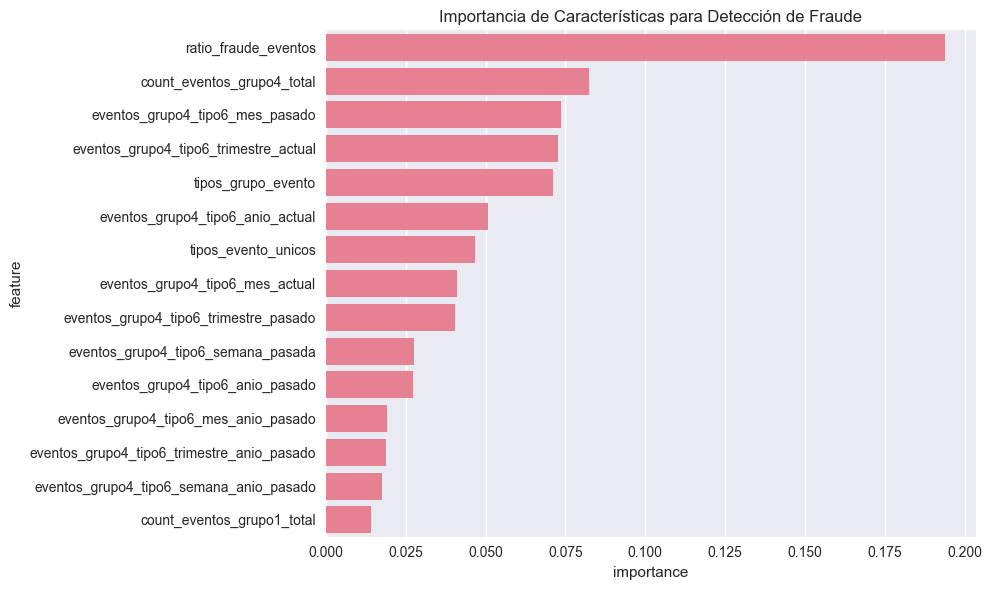

In [13]:
# Método 3: Análisis de características importantes
if y.sum() > 0:
    # Importancia de características
    feature_importance = pd.DataFrame({
        'feature': columnas_validas + ['ratio_fraude_eventos', 'actividad_eventos'],
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 características más importantes:")
    print(feature_importance.head(10))
    
    # Visualizar importancia
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('Importancia de Características para Detección de Fraude')
    plt.tight_layout()
    plt.show()

## 6. Identificación de los 20 Clientes con Mayor Riesgo de Fraude No Detectado

In [14]:
# Combinar diferentes métodos para obtener score final
# Excluir clientes con fraude ya conocido
clientes_sin_fraude_conocido = ~y

# Crear scores combinados
scores_combinados = pd.DataFrame({
    'cups': clientes_ids,
    'anomaly_score': anomaly_probs,
    'fraud_probability': fraud_probabilities if y.sum() > 0 else anomaly_probs,
    'fraude_conocido': y,
    'total_eventos': datos_modelo['total_eventos'].fillna(0),
    'eventos_fraude': datos_modelo['eventos_fraude'].fillna(0)
})

# Filtrar solo clientes sin fraude conocido
candidatos_fraude = scores_combinados[clientes_sin_fraude_conocido].copy()

# Crear score final combinado (promedio ponderado)
if y.sum() > 0:
    candidatos_fraude['score_final'] = (
        0.6 * candidatos_fraude['fraud_probability'] + 
        0.4 * candidatos_fraude['anomaly_score']
    )
else:
    candidatos_fraude['score_final'] = candidatos_fraude['anomaly_score']

# Ordenar por score final y obtener top 20
top_20_riesgo = candidatos_fraude.nlargest(20, 'score_final')

print("TOP 20 CLIENTES CON MAYOR RIESGO DE FRAUDE NO DETECTADO:")
print("=" * 60)
for i, (idx, cliente) in enumerate(top_20_riesgo.iterrows(), 1):
    print(f"{i:2d}. Cliente: {cliente['cups']}")
    print(f"    Score Final: {cliente['score_final']:.4f}")
    print(f"    Prob. Fraude: {cliente['fraud_probability']:.4f}")
    print(f"    Score Anomalía: {cliente['anomaly_score']:.4f}")
    print(f"    Total Eventos: {int(cliente['total_eventos'])}")
    print()

TOP 20 CLIENTES CON MAYOR RIESGO DE FRAUDE NO DETECTADO:
 1. Cliente: ES0022000005035173ZT1P
    Score Final: 0.5398
    Prob. Fraude: 0.2800
    Score Anomalía: 0.9295
    Total Eventos: 224

 2. Cliente: ES0022000008625719TQ1P
    Score Final: 0.5336
    Prob. Fraude: 0.3100
    Score Anomalía: 0.8690
    Total Eventos: 166

 3. Cliente: ES0022000005536315KH1P
    Score Final: 0.5308
    Prob. Fraude: 0.2600
    Score Anomalía: 0.9370
    Total Eventos: 350

 4. Cliente: ES0022000008498425DG1P
    Score Final: 0.5231
    Prob. Fraude: 0.2800
    Score Anomalía: 0.8877
    Total Eventos: 241

 5. Cliente: ES0022000009055059ZS1P
    Score Final: 0.5158
    Prob. Fraude: 0.2800
    Score Anomalía: 0.8696
    Total Eventos: 263

 6. Cliente: ES0022000007395826WW1P
    Score Final: 0.5154
    Prob. Fraude: 0.2800
    Score Anomalía: 0.8685
    Total Eventos: 83

 7. Cliente: ES0022000005157824XS1P
    Score Final: 0.5105
    Prob. Fraude: 0.2500
    Score Anomalía: 0.9013
    Total Evento

In [15]:
# Crear lista final de los 20 clientes
lista_clientes_riesgo = top_20_riesgo['cups'].tolist()

print("LISTA DE LOS 20 CLIENTES CON MAYOR PROBABILIDAD DE FRAUDE NO DETECTADO:")
print("=" * 70)
for i, cliente in enumerate(lista_clientes_riesgo, 1):
    score = top_20_riesgo.iloc[i-1]['score_final']
    print(f"{i:2d}. {cliente} (Score: {score:.4f})")

# Guardar resultados
resultados_df = top_20_riesgo[['cups', 'score_final', 'fraud_probability', 'anomaly_score', 'total_eventos']].copy()
resultados_df.to_csv('../data/outputs/top_20_clientes_riesgo_fraude.csv', index=False)
print(f"\nResultados guardados en: ../data/outputs/top_20_clientes_riesgo_fraude.csv")

LISTA DE LOS 20 CLIENTES CON MAYOR PROBABILIDAD DE FRAUDE NO DETECTADO:
 1. ES0022000005035173ZT1P (Score: 0.5398)
 2. ES0022000008625719TQ1P (Score: 0.5336)
 3. ES0022000005536315KH1P (Score: 0.5308)
 4. ES0022000008498425DG1P (Score: 0.5231)
 5. ES0022000009055059ZS1P (Score: 0.5158)
 6. ES0022000007395826WW1P (Score: 0.5154)
 7. ES0022000005157824XS1P (Score: 0.5105)
 8. ES0022000005543924FZ1P (Score: 0.5070)
 9. ES0022000008042513NK1P (Score: 0.5055)
10. ES0022000007392223YX1P (Score: 0.5032)
11. ES0022000008202572AT1P (Score: 0.5020)
12. ES0022000007864443KV1P (Score: 0.4990)
13. ES0022000007562828HR1P (Score: 0.4977)
14. ES0022000008456239ST1P (Score: 0.4976)
15. ES0022000007892484KK1P (Score: 0.4964)
16. ES0022000005496488SG1P (Score: 0.4883)
17. ES0022000007509973CT1P (Score: 0.4867)
18. ES0022000008142961XM1P (Score: 0.4833)
19. ES0022000005544180HV1P (Score: 0.4806)
20. ES0022000008698202RA1P (Score: 0.4800)

Resultados guardados en: ../data/outputs/top_20_clientes_riesgo_fra

## 7. Análisis y Visualizaciones

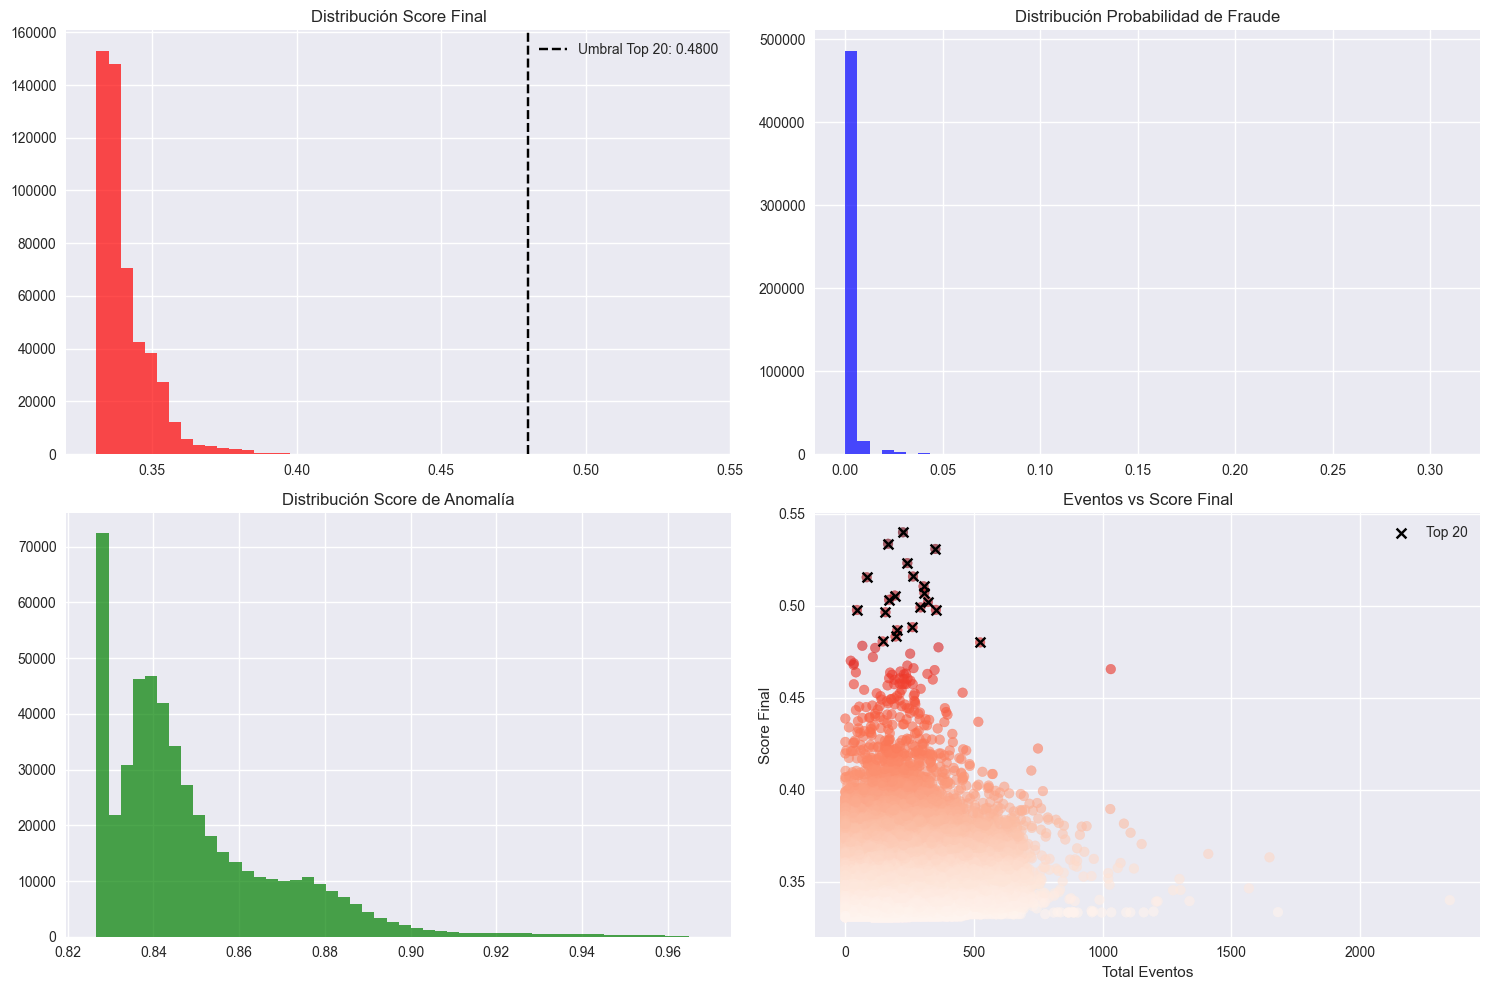

In [16]:
# Visualizar distribución de scores
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Score final
axes[0,0].hist(candidatos_fraude['score_final'], bins=50, alpha=0.7, color='red')
axes[0,0].axvline(top_20_riesgo['score_final'].min(), color='black', linestyle='--', 
                  label=f'Umbral Top 20: {top_20_riesgo["score_final"].min():.4f}')
axes[0,0].set_title('Distribución Score Final')
axes[0,0].legend()

# Probabilidad de fraude
if y.sum() > 0:
    axes[0,1].hist(candidatos_fraude['fraud_probability'], bins=50, alpha=0.7, color='blue')
    axes[0,1].set_title('Distribución Probabilidad de Fraude')

# Score de anomalía
axes[1,0].hist(candidatos_fraude['anomaly_score'], bins=50, alpha=0.7, color='green')
axes[1,0].set_title('Distribución Score de Anomalía')

# Total eventos vs Score final
scatter = axes[1,1].scatter(candidatos_fraude['total_eventos'], candidatos_fraude['score_final'], 
                           alpha=0.6, c=candidatos_fraude['score_final'], cmap='Reds')
axes[1,1].scatter(top_20_riesgo['total_eventos'], top_20_riesgo['score_final'], 
                  color='black', s=50, marker='x', label='Top 20')
axes[1,1].set_xlabel('Total Eventos')
axes[1,1].set_ylabel('Score Final')
axes[1,1].set_title('Eventos vs Score Final')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [17]:
# Estadísticas comparativas
print("ESTADÍSTICAS COMPARATIVAS:")
print("=" * 40)

print("Clientes con fraude conocido:")
conocidos_stats = scores_combinados[scores_combinados['fraude_conocido']]
if len(conocidos_stats) > 0:
    print(f"  Promedio total_eventos: {conocidos_stats['total_eventos'].mean():.2f}")
    print(f"  Promedio anomaly_score: {conocidos_stats['anomaly_score'].mean():.4f}")
    if y.sum() > 0:
        print(f"  Promedio fraud_probability: {conocidos_stats['fraud_probability'].mean():.4f}")

print("\nTop 20 clientes de riesgo:")
print(f"  Promedio total_eventos: {top_20_riesgo['total_eventos'].mean():.2f}")
print(f"  Promedio anomaly_score: {top_20_riesgo['anomaly_score'].mean():.4f}")
if y.sum() > 0:
    print(f"  Promedio fraud_probability: {top_20_riesgo['fraud_probability'].mean():.4f}")

print("\nTodos los clientes sin fraude conocido:")
print(f"  Promedio total_eventos: {candidatos_fraude['total_eventos'].mean():.2f}")
print(f"  Promedio anomaly_score: {candidatos_fraude['anomaly_score'].mean():.4f}")
if y.sum() > 0:
    print(f"  Promedio fraud_probability: {candidatos_fraude['fraud_probability'].mean():.4f}")

ESTADÍSTICAS COMPARATIVAS:
Clientes con fraude conocido:
  Promedio total_eventos: 215.30
  Promedio anomaly_score: 0.8746
  Promedio fraud_probability: 0.9944

Top 20 clientes de riesgo:
  Promedio total_eventos: 239.65
  Promedio anomaly_score: 0.8923
  Promedio fraud_probability: 0.2465

Todos los clientes sin fraude conocido:
  Promedio total_eventos: 130.88
  Promedio anomaly_score: 0.8497
  Promedio fraud_probability: 0.0009


## Conclusiones

Basándose en el análisis de las cuatro tablas y utilizando técnicas de machine learning y detección de anomalías, se han identificado los 20 clientes con mayor probabilidad de estar cometiendo fraude sin haber sido detectados.

**Metodología utilizada:**
1. **Isolation Forest**: Para detectar patrones anómalos en el comportamiento de los clientes
2. **Random Forest**: Para aprender de los casos de fraude conocidos (si existen suficientes)
3. **Ingeniería de características**: Combinación de datos de contadores, expedientes, métricas y eventos
4. **Score combinado**: Fusión de diferentes métodos para obtener una puntuación final de riesgo

**Los 20 clientes identificados** muestran patrones de comportamiento similares a los casos de fraude conocidos o presentan anomalías significativas en sus métricas operacionales.

Se recomienda investigar estos clientes en orden de prioridad según su score final.